# Engineering Management 585 - Fundamentals of Data Science
## Final Project - Customer Segment Analysis
### Team Data 4 - Chen Bian, Lanyu Dong, Naman Satiya

In [936]:
#Initiate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Step 1: Basic information and visualization of our dataset
Reading File from the csv

In [845]:
#read file from csv
df = pd.read_csv("marketing_campaign.csv", delimiter = '\t')
print(df.shape)
print(df.head())
print(df.columns)

(2240, 29)
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0   

### Step 2: Finding any missing Data:
Found that 'Income' had some missing data. 
Replaced it with the median of all other incomes replaced one outlier with median value

In [846]:
#Find Missing Data:

for i in df.columns:
    null_rate = df[i].isna().sum()/len(df) * 100
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))
        
#How to add the missing data in 'Income' column.?? Currently using Median of all other data
df['Income'].replace(np.nan, np.nanmedian(df.Income), inplace=True)

df['Income'].replace(666666.0, np.nanmedian(df.Income), inplace=True)

Income null rate: 1.07%


# # Step 3: Remove Unwanted Columns

Added Column for Customer Age

In [847]:
df.insert(loc=1, column='Age', value=2020 - df['Year_Birth'])
df.drop(['Z_CostContact', 'Z_Revenue', 'Year_Birth'], axis = 1, inplace=True)

print(df.head())
print((df.columns))

     ID  Age   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524   63  Graduation         Single  58138.0        0         0   
1  2174   66  Graduation         Single  46344.0        1         1   
2  4141   55  Graduation       Together  71613.0        0         0   
3  6182   36  Graduation       Together  26646.0        1         0   
4  5324   39         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  NumStorePurchases  \
0  04-09-2012       58       635  ...                   10                  4   
1  08-03-2014       38        11  ...                    1                  2   
2  21-08-2013       26       426  ...                    2                 10   
3  10-02-2014       26        11  ...                    0                  4   
4  19-01-2014       94       173  ...                    3                  6   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0     

# Step 4: Exploratory Data Analytics:

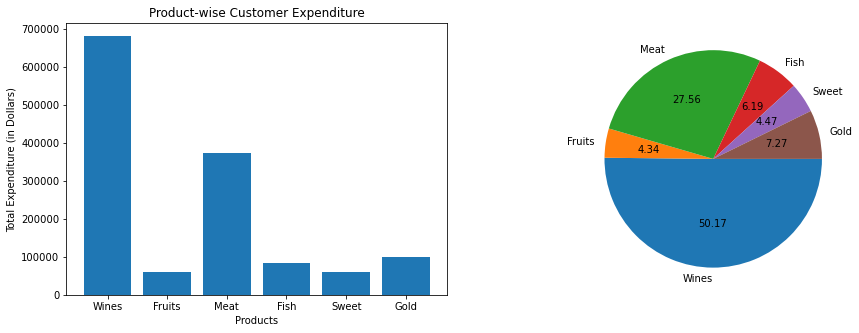

In [848]:
#Amount Spend comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

spend_data = [np.sum(df.MntWines), np.sum(df.MntFruits), np.sum(df.MntMeatProducts), 
                      np.sum(df.MntFishProducts), np.sum(df.MntSweetProducts), np.sum(df.MntGoldProds)]
labels = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']
ax1.bar(labels, spend_data)
ax1.set_title('Product-wise Customer Expenditure')
ax1.set_xlabel('Products')
ax1.set_ylabel("Total Expenditure (in Dollars)")


#Percentage Calculation:
total_expense = np.sum(spend_data)
spend_data_percent = [np.sum(df.MntWines)*100/total_expense, np.sum(df.MntFruits)*100/total_expense, 
                     np.sum(df.MntMeatProducts)*100/total_expense, np.sum(df.MntFishProducts)*100/total_expense, 
                     np.sum(df.MntSweetProducts)*100/total_expense, np.sum(df.MntGoldProds)*100/total_expense]
ax2.pie(spend_data_percent, labels = labels, counterclock = False, autopct='%.2f')

plt.show()

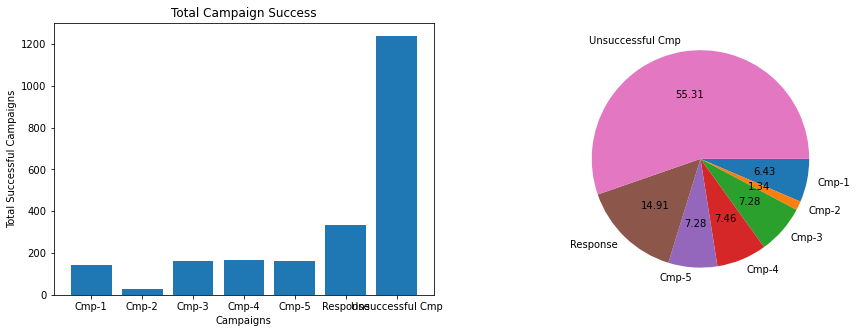

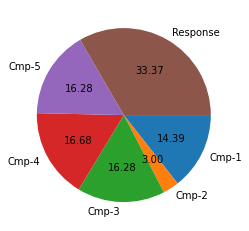

In [849]:
#Successful Campaign comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

cmp_list = [np.sum(df.AcceptedCmp1), np.sum(df.AcceptedCmp2), np.sum(df.AcceptedCmp3), 
                      np.sum(df.AcceptedCmp4), np.sum(df.AcceptedCmp5), np.sum(df.Response)]
n_unsucc_cmp = len(df) - np.sum(cmp_list)
cmp_list.append(n_unsucc_cmp)
labels = ['Cmp-1', 'Cmp-2', 'Cmp-3', 'Cmp-4', 'Cmp-5', 'Response', 'Unsuccessful Cmp']
ax1.bar(labels, cmp_list)
ax1.set_title('Total Campaign Success')
ax1.set_xlabel('Campaigns')
ax1.set_ylabel("Total Successful Campaigns")

#Percentage Calculation:
total_cmps = np.sum(cmp_list)
cmp_data_percent = [np.sum(df.AcceptedCmp1)*100/total_cmps, np.sum(df.AcceptedCmp2)*100/total_cmps, 
                     np.sum(df.AcceptedCmp3)*100/total_cmps, np.sum(df.AcceptedCmp4)*100/total_cmps, 
                     np.sum(df.AcceptedCmp5)*100/total_cmps, np.sum(df.Response)*100/total_cmps, 
                     n_unsucc_cmp*100/total_cmps]
ax2.pie(cmp_data_percent, labels = labels, counterclock = False, autopct='%.2f')
plt.show()


#Percentage Calculation for Successful Campaigns
labels = ['Cmp-1', 'Cmp-2', 'Cmp-3', 'Cmp-4', 'Cmp-5', 'Response']
total_cmps = np.sum(cmp_list) - n_unsucc_cmp
cmp_data_percent = [np.sum(df.AcceptedCmp1)*100/total_cmps, np.sum(df.AcceptedCmp2)*100/total_cmps, 
                     np.sum(df.AcceptedCmp3)*100/total_cmps, np.sum(df.AcceptedCmp4)*100/total_cmps, 
                     np.sum(df.AcceptedCmp5)*100/total_cmps, np.sum(df.Response)*100/total_cmps]
plt.pie(cmp_data_percent, labels = labels, counterclock = False, autopct='%.2f')
plt.show()

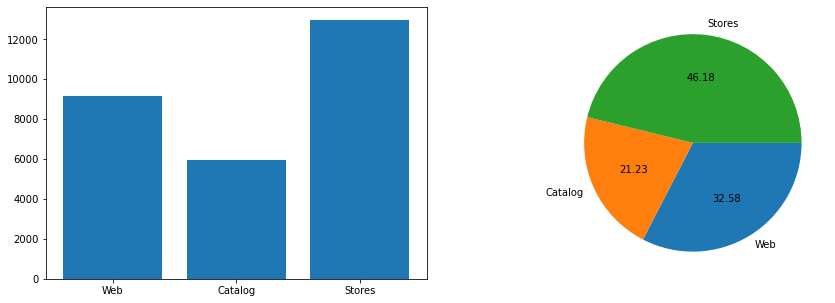

In [850]:
#Number of purchases comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

pur_list = [np.sum(df.NumWebPurchases), np.sum(df.NumCatalogPurchases), np.sum(df.NumStorePurchases)]
labels = ['Web', 'Catalog', 'Stores']
ax1.bar(labels, pur_list)

#Percentage Calculation:
total_pur = np.sum(pur_list)
pur_data_percent = [np.sum(df.NumWebPurchases)*100/total_cmps, np.sum(df.NumCatalogPurchases)*100/total_cmps, 
                     np.sum(df.NumStorePurchases)*100/total_cmps]
ax2.pie(pur_data_percent, labels = labels, counterclock = False, autopct='%.2f')

plt.show()

In [851]:
#Purchace Place based on Total Spending, Wines and Meat
df["Successful Campaign"] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['Total_Orders'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
df['Total_Spend'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Spend_per_Order'] = df['Total_Spend'] / df['Total_Orders']
df['Web_percent'] = df['NumWebPurchases'] / df['Total_Orders']
df['Cat_percent'] = df['NumCatalogPurchases'] / df['Total_Orders']
df['Store_percent'] = df['NumStorePurchases'] / df['Total_Orders']

df = df.drop(df[df['Total_Orders'] == 0].index)
df = df.drop(df[df['Spend_per_Order'] > 1000].index)
df_temp1 = df.where(df['Spend_per_Order'] > 0.23*np.max(df['Spend_per_Order'])).dropna()

print(len(df_temp1))
print(np.average(df_temp1['Web_percent']))
print(np.average(df_temp1['Cat_percent']))
print(np.average(df_temp1['Store_percent']))
print(np.average(df_temp1['Spend_per_Order']))

673
0.2819051359762508
0.2901932415165744
0.4279016225071748
75.58818574192317


In [852]:
df_temp2 = df.where(df['Total_Spend'] < 12*np.min(df['Total_Spend'])).dropna()
df_temp2 = df
print(len(df_temp2))
print(np.average(df_temp2['Web_percent']))
print(np.average(df_temp2['Cat_percent']))
print(np.average(df_temp2['Store_percent']))
print(np.average(df_temp2['Spend_per_Order']))
print(np.average(df_temp2['Total_Orders']))

2233
0.3300219768604646
0.16488272568124732
0.5050952974582881
37.47102902398174
12.57590685176892


In [853]:
df_temp3 = df[['Web_percent', 'Cat_percent', 'Store_percent', 'Total_Orders', 'Total_Spend', 'MntWines',
               'MntMeatProducts', 'MntGoldProds', 'MntFishProducts']]

corr = df_temp3.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))
#corr = df_temp3.corr().where(pd.np.triu(pd.np.ones(df_temp3.shape), k=1).astype(bool)).stack().reset_index()

corr.style.background_gradient(cmap='coolwarm')

,Web_percent,Cat_percent,Store_percent,Total_Orders,Total_Spend,MntWines,MntMeatProducts,MntGoldProds,MntFishProducts
Web_percent,1.000000,-0.360645,-0.475747,-0.060315,-0.209741,-0.125060,-0.268589,-0.008324,-0.198326
Cat_percent,-0.360645,1.000000,-0.648813,0.590973,0.660826,0.524042,0.625946,0.410463,0.470989
Store_percent,-0.475747,-0.648813,1.000000,-0.508106,-0.452071,-0.392165,-0.371167,-0.380294,-0.282359
Total_Orders,-0.060315,0.590973,-0.508106,1.000000,0.822813,0.756160,0.633631,0.511131,0.536910
Total_Spend,-0.209741,0.660826,-0.452071,0.822813,1.000000,0.893001,0.845982,0.523963,0.643128
MntWines,-0.125060,0.524042,-0.392165,0.756160,0.893001,1.000000,0.569517,0.386218,0.398715
MntMeatProducts,-0.268589,0.625946,-0.371167,0.633631,0.845982,0.569517,1.000000,0.354018,0.574452
MntGoldProds,-0.008324,0.410463,-0.380294,0.511131,0.523963,0.386218,0.354018,1.000000,0.421977
MntFishProducts,-0.198326,0.470989,-0.282359,0.536910,0.643128,0.398715,0.574452,0.421977,1.000000


Finding the correlation Matrix among all inputs and outputs

In [855]:
X_corr = df[['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

corr = X_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
Age,1.000000,0.197870,-0.230547,0.352775,0.019669,0.158395,0.018141,0.033882,0.041948,0.018366,0.062308
Income,0.197870,1.000000,-0.515215,0.036806,0.000917,0.697685,0.513752,0.702031,0.527222,0.526643,0.390947
Kidhome,-0.230547,-0.515215,1.000000,-0.037935,0.009804,-0.498326,-0.373848,-0.440056,-0.388914,-0.371917,-0.350976
Teenhome,0.352775,0.036806,-0.037935,1.000000,0.017459,0.003008,-0.178428,-0.262671,-0.205922,-0.164109,-0.023337
Recency,0.019669,0.000917,0.009804,0.017459,1.000000,0.016729,-0.003876,0.023391,0.001539,0.023137,0.017280
MntWines,0.158395,0.697685,-0.498326,0.003008,0.016729,1.000000,0.388596,0.569517,0.398715,0.385550,0.386218
MntFruits,0.018141,0.513752,-0.373848,-0.178428,-0.003876,0.388596,1.000000,0.549351,0.594286,0.566621,0.392083
MntMeatProducts,0.033882,0.702031,-0.440056,-0.262671,0.023391,0.569517,0.549351,1.000000,0.574452,0.529731,0.354018
MntFishProducts,0.041948,0.527222,-0.388914,-0.205922,0.001539,0.398715,0.594286,0.574452,1.000000,0.579337,0.421977
MntSweetProducts,0.018366,0.526643,-0.371917,-0.164109,0.023137,0.385550,0.566621,0.529731,0.579337,1.000000,0.368781


# Step 5: Updating the DataFrame columns to get more insights:
Successful Campaign = Sum of all 5 Campaigns

Total Spend = Sum of spends across all products

Living_With: Converting 'Marital Status' into a 2 state input (With Partner and Alone)

Children = Total Number of children = Kidhome + Teenhome

Family_Size = Total People in the house = Parents + Kids

Is_Parnt = Binary state to specify if they are parents or not

Dropped unwanted columns

In [856]:
df["Successful Campaign"] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

df['Total_Spend'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

## To get a more clarity about family's background
df["Children"]=df["Kidhome"]+df["Teenhome"]
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

drop_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Marital_Status']
df.drop(drop_cols, inplace = True, axis=1)

In [857]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

df_temp123 = df[['Total_Spend', 'MntWines', 'Is_Parent', 'Store_percent', 'Successful Campaign']]
corr = df_temp123.corr()
corr.style.background_gradient(cmap='coolwarm')


,Total_Spend,MntWines,Is_Parent,Store_percent,Successful Campaign
Total_Spend,1.000000,0.893001,-0.527938,-0.452071,0.458722
MntWines,0.893001,1.000000,-0.347955,-0.392165,0.512559
Is_Parent,-0.527938,-0.347955,1.000000,0.173640,-0.282760
Store_percent,-0.452071,-0.392165,0.173640,1.000000,-0.235410
Successful Campaign,0.458722,0.512559,-0.282760,-0.235410,1.000000


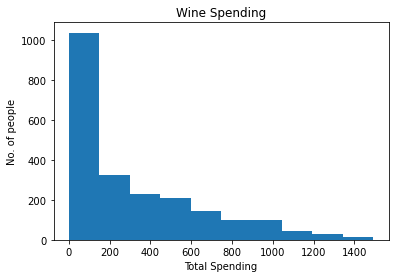

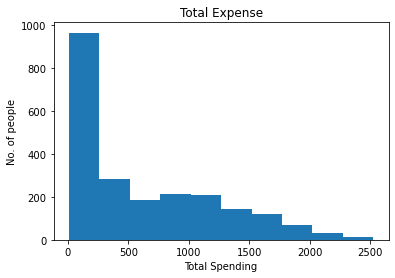

In [858]:
plt.hist(df.MntWines)
plt.xlabel('Total Spending')
plt.ylabel('No. of people')
plt.title('Wine Spending')
plt.show()
plt.hist(df.Total_Spend)
plt.xlabel('Total Spending')
plt.ylabel('No. of people')
plt.title('Total Expense')

plt.show()

# CUSTOMER SEGMENTATION BASED ON TOTAL SPEND 

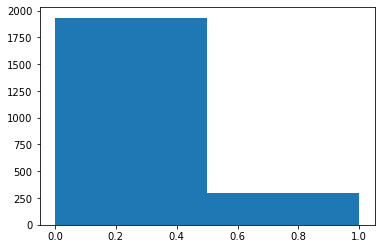

In [920]:
#Creating 3 different actegories
#n_categories = 3

df['Type_of_Buyer'] = 'High'
df['Type_of_Buyer'].loc[df['Total_Spend'] < np.max(df['Total_Spend'])*0.55] = 'Low'
hist = plt.hist(y, bins = 2)

#df['Type_of_Buyer'].replace({'High': 1, 'Low': 0}, inplace = True)

## Logistic Regression Algorithm

The accuracy score of model is 0.872


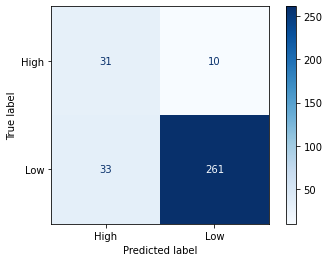

Low
[0.465, 0.283, 0.349, 0.54, 0.531, 0.437, 0.584, 0.471]
[[ 0.14748174 -1.84808643 -0.48376139  0.22091587 -0.89165294  0.12341745
  -0.11381924  0.07257013  0.23384211]]
                      Low  High
Age                  0.54  0.46
Income               0.14  0.86
Successful Campaign  0.38  0.62
Children             0.56  0.44
Cat_percent          0.29  0.71
Family_Size          0.53  0.47
Is_Parent            0.47  0.53
Kidhome              0.52  0.48
Teenhome             0.56  0.44


In [935]:
########## Algorithm ##################
X = df[['Age', 'Income', 'Successful Campaign', 'Children', 'Cat_percent', 'Family_Size', 'Is_Parent', 'Kidhome', 'Teenhome']]
y = df['Type_of_Buyer']
#'Edu-Grad', 'Edu-2n', 'Edu-Masters', 'Edu-PhD', 'Edu-Basic'

# Split into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.15)

#Standardizing the inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model Initialization
model = LogisticRegression(penalty='l2',C=3.6, class_weight = {'Low': 0.11, 'High': 0.45})
#model = RandomForestClassifier (n_estimators=100)


#Model Training and Prediction
model.fit(X_train_scaled,y_train)
y_preds = model.predict(X_test_scaled)
acc_score = accuracy_score(y_test,y_preds)
print('The accuracy score of model is {:.3f}'.format(acc_score))

#Plot Confusion Matrix
plot_confusion_matrix(model, X_test_scaled, y_test,cmap=plt.cm.Blues,normalize=None)
plt.show()

# print(model.get_params(deep=True))
print(model.classes_[1])
print(coef_class_1)
print(model.coef_)

# Get all coefficients of the model 

coef_class_0 = [round(np.exp(x)/(1 + np.exp(x)), 2) for x in model.coef_[0]]
#coef_class_1 = [round(np.exp(x)/(1 + np.exp(x)), 2) for x in model.coef_[1]]
#coef_class_2 = [round(np.exp(x)/(1 + np.exp(x)), 2) for x in model.coef_[2]]

coef_df = pd.DataFrame(coef_class_0, X.columns, columns=[model.classes_[1]])
coef_df['High'] = np.subtract(1,coef_class_0)
#coef_df[model.classes_[1]] = coef_class_1
#coef_df[model.classes_[2]] = coef_class_2
print(coef_df)


## Finding the optimum value of penalty factor 'c' for Logistic Regression

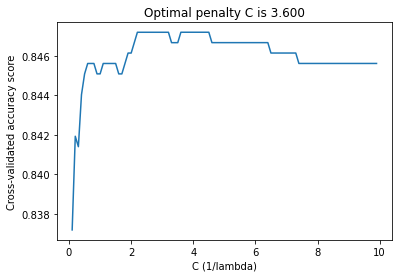

Accuracy on test set is 0.910


In [932]:
# Find optimal penalty factor using cross-validation
# Note that for logistic regression, the penalty factor is C which is 1/lambda

# Use cross-validation to find the optimal C
acc_scores = []
c_vals = np.arange(0.1,10,.1)
for c in c_vals:
    model = LogisticRegression(penalty='l2',C=c, class_weight = {'Low': 0.1, 'High': 0.9})
    scores = cross_val_score(model,X_train_scaled,y_train,scoring='accuracy',cv=5)
    acc_scores.append(np.mean(scores))

plt.plot(c_vals,acc_scores)
opt_c = c_vals[np.argmax(acc_scores)]
plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
plt.xlabel('C (1/lambda)')
plt.ylabel('Cross-validated accuracy score')
plt.show()


# Retrain the final model on the full training set and calculate the test set accuracy
final_model = LogisticRegression(penalty='l2',C=opt_c,random_state=0)
final_model.fit(X_train_scaled,y_train)
test_preds = final_model.predict(X_test_scaled)
acc_score = accuracy_score(y_test,test_preds)
print('Accuracy on test set is {:.3f}'.format(acc_score))

     ID  Age   Education   Income  Kidhome  Teenhome Dt_Customer  Recency  \
0  5524   63  Graduation  58138.0        0         0  04-09-2012       58   
1  2174   66  Graduation  46344.0        1         1  08-03-2014       38   
2  4141   55  Graduation  71613.0        0         0  21-08-2013       26   
3  6182   36  Graduation  26646.0        1         0  10-02-2014       26   
4  5324   39         PhD  58293.0        1         0  19-01-2014       94   

   MntWines  MntFruits  ...  NumWebVisitsMonth  Complain  Response  \
0       635         88  ...                  7         0         1   
1        11          1  ...                  5         0         0   
2       426         49  ...                  4         0         0   
3        11          4  ...                  6         0         0   
4       173         43  ...                  5         0         0   

   Successful Campaign  Total Spend  Living_With  Children  Family_Size  \
0                    0         1617      

<AxesSubplot:xlabel='Income', ylabel='Total Spend'>

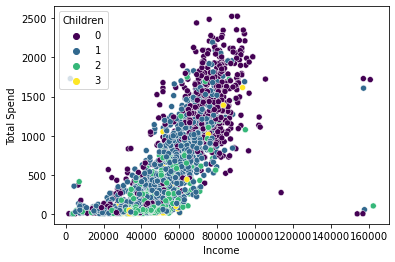

In [365]:
#X['Type of Buyer'] = df['Type of Buyer']
print(df.head())
sns.scatterplot(data = df,x = 'Income', y = 'Total_Spend', hue = 'Children', palette = 'viridis')

In [639]:
df_top_Total_Spend = df.where(df['Total_Spend'] > 0.57*np.max(df['Total_Spend'])).dropna()
df_top_Total_Spend = df.where(df['Total_Spend'] > 0.57*np.max(df['Total_Spend'])).dropna()
#print(df_top_Total_Spend.head())

df_top_MntWines = df.where(df['MntWines'] > 0.57*np.max(df['MntWines'])).dropna()
df_top_MntWines = df.where(df['MntWines'] > 0.57*np.max(df['MntWines'])).dropna()
#print(df_top_MntWines.head())

df_top_MntMeat = df.where(df['MntMeatProducts'] > 0.3*np.max(df['MntMeatProducts'])).dropna()
df_top_MntMeat = df.where(df['MntMeatProducts'] > 0.3*np.max(df['MntMeatProducts'])).dropna()
print(df_top_MntMeat.shape)

(209, 28)


## Finding the Difference between the Average Buyers and top 10% Buyer Characteristics

                     Avg - Top 10%   Avg - Total  Diff % (Top-Avg/Top)
Attribute                                                             
Income                75022.348558  51963.294866                 30.74
Kidhome                   0.081731      0.444196               -443.49
Teenhome                  0.394231      0.506250                -28.41
MntWines               1060.447115    303.935714                 71.34
NumDealsPurchases         2.004808      2.325000                -15.97
NumCatalogPurchases       5.572115      2.662054                 52.23
Successful Campaign       1.288462      0.297768                 76.89
Total_Spend            1671.942308    605.798214                 63.77
Edu > Masters            62.019231     38.214286                 38.38
129
208


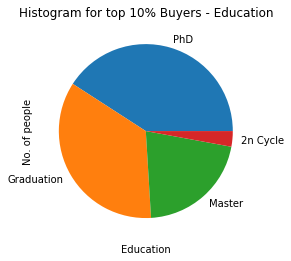

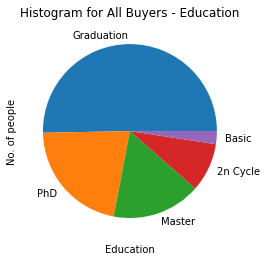

In [620]:
df_Mntwines_cmp = pd.DataFrame()
df_Mntwines_cmp['Attribute'] = ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'NumDealsPurchases', 'NumCatalogPurchases', 'Successful Campaign']
df_Mntwines_cmp.index = df_Mntwines_cmp['Attribute']
#df_Mntwines_cmp.drop(['ID', 'Dt_Customer', 'Recency', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Response'], axis = 0, inplace = True)
df_Mntwines_cmp.drop(['Attribute'], axis = 1, inplace = True)

df_Mntwines_cmp['Avg - Top 10%'] = 0
df_Mntwines_cmp['Avg - Total'] = 0


for row in ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'NumDealsPurchases', 'NumCatalogPurchases', 'Successful Campaign', 'Total_Spend']:
    df_Mntwines_cmp.loc[row, 'Avg - Total'] = np.mean(df[row])
    df_Mntwines_cmp.loc[row, 'Avg - Top 10%'] = np.mean(df_top_MntWines[row])
    
df_Mntwines_cmp.loc['Edu > Masters', 'Avg - Total'] = len(df.where(df["Education"].isin(['Master', 'PhD'])).dropna())*100/len(df)
df_Mntwines_cmp.loc['Edu > Masters', 'Avg - Top 10%'] = len(df_top_MntWines.where(df_top_MntWines["Education"].isin(['Master', 'PhD'])).dropna())*100/len(df_top_MntWines)
df_Mntwines_cmp['Diff % (Top-Avg/Top)'] = round((df_Mntwines_cmp['Avg - Top 10%'] - df_Mntwines_cmp['Avg - Total'])*100 / df_Mntwines_cmp['Avg - Top 10%'], 2)

print(df_Mntwines_cmp)
print(len(df_top_MntWines.where(df_top_MntWines["Education"].isin(['Master', 'PhD'])).dropna()))
print(len(df_top_MntWines))

#top_education: 
#(n, bins, patches) = plt.hist(df_top_Total_Spend.Education, density = True)
df_top_MntWines['Education'].value_counts().plot(kind = 'pie')
plt.xlabel('Education')
plt.ylabel('No. of people')
plt.title('Histogram for top 10% Buyers - Education')
plt.show()

#plt.hist(df.Education, density = True)
df['Education'].value_counts().plot(kind = 'pie')
plt.xlabel('Education')
plt.ylabel('No. of people')
plt.title('Histogram for All Buyers - Education')
plt.show()

In [568]:

#Useless: Living_With
#Usefull: Income, Kidhome, Teenhome, MntWines, NumDealsPurchases, NumCatalogPurchases, Successful Campaign
print(np.average(df_top_Total_Spend['Family_Size']))
print(np.average(df['Family_Size']))

1.900355871886121
2.5950892857142858


                     Avg - Top 10%   Avg - Total  Diff % (Top-Avg/Top)
Attribute                                                             
Income                78666.866548  51963.294866                 33.95
Kidhome                   0.060498      0.444196               -634.23
Teenhome                  0.206406      0.506250               -145.27
MntWines                867.512456    303.935714                 64.96
NumDealsPurchases         1.540925      2.325000                -50.88
NumCatalogPurchases       6.434164      2.662054                 58.63
Successful Campaign       1.056940      0.297768                 71.83
Total_Spend            1758.103203    605.798214                 65.54
Edu > Masters            29.893238     38.214286                -27.84
123
281


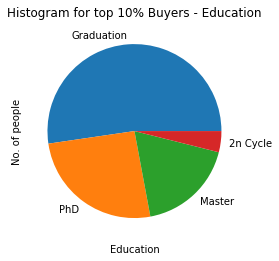

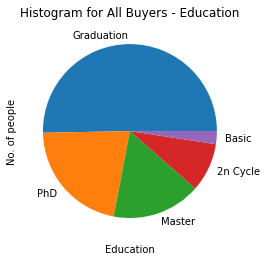

In [621]:
df_Total_Spend_cmp = pd.DataFrame()
df_Total_Spend_cmp['Attribute'] = ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'NumDealsPurchases', 'NumCatalogPurchases', 'Successful Campaign']
df_Total_Spend_cmp.index = df_Total_Spend_cmp['Attribute']
#df_Mntwines_cmp.drop(['ID', 'Dt_Customer', 'Recency', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Response'], axis = 0, inplace = True)
df_Total_Spend_cmp.drop(['Attribute'], axis = 1, inplace = True)

df_Total_Spend_cmp['Avg - Top 10%'] = 0
df_Total_Spend_cmp['Avg - Total'] = 0


for row in ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'NumDealsPurchases', 'NumCatalogPurchases', 'Successful Campaign', 'Total_Spend']:
    df_Total_Spend_cmp.loc[row, 'Avg - Total'] = np.mean(df[row])
    df_Total_Spend_cmp.loc[row, 'Avg - Top 10%'] = np.mean(df_top_Total_Spend[row])
    
df_Total_Spend_cmp.loc['Edu > Masters', 'Avg - Total'] = len(df.where(df["Education"].isin(['Master', 'PhD'])).dropna())*100/len(df)
df_Total_Spend_cmp.loc['Edu > Masters', 'Avg - Top 10%'] = len(df_top_Total_Spend.where(df_top_MntWines["Education"].isin(['Master', 'PhD'])).dropna())*100/len(df_top_Total_Spend)
df_Total_Spend_cmp['Diff % (Top-Avg/Top)'] = round((df_Total_Spend_cmp['Avg - Top 10%'] - df_Total_Spend_cmp['Avg - Total'])*100 / df_Total_Spend_cmp['Avg - Top 10%'], 2)

print(df_Total_Spend_cmp)
print(len(df_top_Total_Spend.where(df_top_Total_Spend["Education"].isin(['Master', 'PhD'])).dropna()))
print(len(df_top_Total_Spend))

#top_education: 
#(n, bins, patches) = plt.hist(df_top_Total_Spend.Education, density = True)
df_top_Total_Spend['Education'].value_counts().plot(kind = 'pie')
plt.xlabel('Education')
plt.ylabel('No. of people')
plt.title('Histogram for top 10% Buyers - Education')
plt.show()

#plt.hist(df.Education, density = True)
df['Education'].value_counts().plot(kind = 'pie')
plt.xlabel('Education')
plt.ylabel('No. of people')
plt.title('Histogram for All Buyers - Education')
plt.show()

                     Avg - Top 10%   Avg - Total  Diff % (Top-Avg/Top)
Attribute                                                             
Income                80243.098086  51963.294866                 35.24
Kidhome                   0.009569      0.444196              -4541.85
Teenhome                  0.062201      0.506250               -713.89
MntWines                650.038278    303.935714                 53.24
NumDealsPurchases         1.229665      2.325000                -89.08
NumCatalogPurchases       6.679426      2.662054                 60.15
Successful Campaign       0.799043      0.297768                 62.73
Total_Spend            1687.626794    605.798214                 64.10
Edu > Masters            39.712919     38.214286                  3.77
83
209


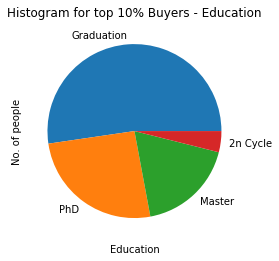

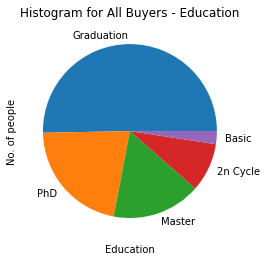

In [642]:
df_MntMeat_cmp = pd.DataFrame()
df_MntMeat_cmp['Attribute'] = ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'NumDealsPurchases', 'NumCatalogPurchases', 'Successful Campaign']
df_MntMeat_cmp.index = df_MntMeat_cmp['Attribute']
#df_Mntwines_cmp.drop(['ID', 'Dt_Customer', 'Recency', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Response'], axis = 0, inplace = True)
df_MntMeat_cmp.drop(['Attribute'], axis = 1, inplace = True)

df_MntMeat_cmp['Avg - Top 10%'] = 0
df_MntMeat_cmp['Avg - Total'] = 0


for row in ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'NumDealsPurchases', 'NumCatalogPurchases', 'Successful Campaign', 'Total_Spend']:
    df_MntMeat_cmp.loc[row, 'Avg - Total'] = np.mean(df[row])
    df_MntMeat_cmp.loc[row, 'Avg - Top 10%'] = np.mean(df_top_MntMeat[row])
    
df_MntMeat_cmp.loc['Edu > Masters', 'Avg - Total'] = len(df.where(df["Education"].isin(['Master', 'PhD'])).dropna())*100/len(df)
df_MntMeat_cmp.loc['Edu > Masters', 'Avg - Top 10%'] = len(df_top_MntMeat.where(df_top_MntMeat["Education"].isin(['Master', 'PhD'])).dropna())*100/len(df_top_MntMeat)
df_MntMeat_cmp['Diff % (Top-Avg/Top)'] = round((df_MntMeat_cmp['Avg - Top 10%'] - df_MntMeat_cmp['Avg - Total'])*100 / df_MntMeat_cmp['Avg - Top 10%'], 2)

print(df_MntMeat_cmp)
print(len(df_top_MntMeat.where(df_top_MntMeat["Education"].isin(['Master', 'PhD'])).dropna()))
print(len(df_top_MntMeat))

#top_education: 
#(n, bins, patches) = plt.hist(df_top_Total_Spend.Education, density = True)
df_top_Total_Spend['Education'].value_counts().plot(kind = 'pie')
plt.xlabel('Education')
plt.ylabel('No. of people')
plt.title('Histogram for top 10% Buyers - Education')
plt.show()

#plt.hist(df.Education, density = True)
df['Education'].value_counts().plot(kind = 'pie')
plt.xlabel('Education')
plt.ylabel('No. of people')
plt.title('Histogram for All Buyers - Education')
plt.show()

In [643]:
#print(df_Total_Spend_cmp)
#print(df_Mntwines_cmp)
df_comparison = pd.DataFrame()


df_comparison['Avg-Total'] = df_Total_Spend_cmp['Avg - Total']
df_comparison['Total - top10%'] = df_Total_Spend_cmp['Avg - Top 10%']
df_comparison['Wines - top10%'] = df_Mntwines_cmp['Avg - Top 10%']
df_comparison['Meat - top10%'] = df_MntMeat_cmp['Avg - Top 10%']
print(df_comparison)

                        Avg-Total  Total - top10%  Wines - top10%  \
Attribute                                                           
Income               51963.294866    78666.866548    75022.348558   
Kidhome                  0.444196        0.060498        0.081731   
Teenhome                 0.506250        0.206406        0.394231   
MntWines               303.935714      867.512456     1060.447115   
NumDealsPurchases        2.325000        1.540925        2.004808   
NumCatalogPurchases      2.662054        6.434164        5.572115   
Successful Campaign      0.297768        1.056940        1.288462   
Total_Spend            605.798214     1758.103203     1671.942308   
Edu > Masters           38.214286       29.893238       62.019231   

                     Meat - top10%  
Attribute                           
Income                80243.098086  
Kidhome                   0.009569  
Teenhome                  0.062201  
MntWines                650.038278  
NumDealsPurchases 